In [1]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
set.seed(42)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.5.1 but the current version is
4.5.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:

library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
set.seed(42)


data_dir <- "/projects/mipt_dbmp_biotechnology/single_cell/H068_sample_filtered_feature_bc_matrix"
pbmc.data <- Read10X(data.dir = data_dir)

10X data contains more than one type and is being returned as a list containing matrices of each type.



In [4]:
cat("=== ВОПРОС 1 ===\n")
cat("Исходные данные:\n")
cat("Количество клеток:", ncol(pbmc.data$`Gene Expression`), "\n")
cat("Количество генов:", nrow(pbmc.data$`Gene Expression`), "\n")
cat("CellRanger фильтрует 'плохие' клетки на основе:\n")
cat("- Количества обнаруженных генов на клетку\n")
cat("- Количества молекул RNA на клетку\n") 
cat("- Процента митохондриальных транскриптов\n")
cat("- Клетки с аномальными значениями отфильтровываются\n\n")

=== ВОПРОС 1 ===
Исходные данные:
Количество клеток: 9234 
Количество генов: 36601 
CellRanger фильтрует 'плохие' клетки на основе:
- Количества обнаруженных генов на клетку
- Количества молекул RNA на клетку
- Процента митохондриальных транскриптов
- Клетки с аномальными значениями отфильтровываются



In [5]:
GEX.so <- CreateSeuratObject(counts = pbmc.data$`Gene Expression`, 
                            project = "PBMC", 
                            min.cells = 3, 
                            min.features = 200)


In [6]:
cat("=== ВОПРОС 2 ===\n")
cat("После фильтрации min.cells=3, min.features=200:\n")
cat("Количество клеток:", ncol(GEX.so), "\n")
cat("Количество генов:", nrow(GEX.so), "\n")
cat("min.features = 200: отфильтровываются клетки с <200 генов\n")
cat("min.cells = 3: отфильтровываются гены, экспрессированные в <3 клетках\n\n")

=== ВОПРОС 2 ===
После фильтрации min.cells=3, min.features=200:
Количество клеток: 8633 
Количество генов: 22584 
min.features = 200: отфильтровываются клетки с <200 генов
min.cells = 3: отфильтровываются гены, экспрессированные в <3 клетках



In [7]:
GEX.so[["percent.mt"]] <- PercentageFeatureSet(GEX.so, pattern = "^MT-")

=== ВОПРОС 3 ===


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


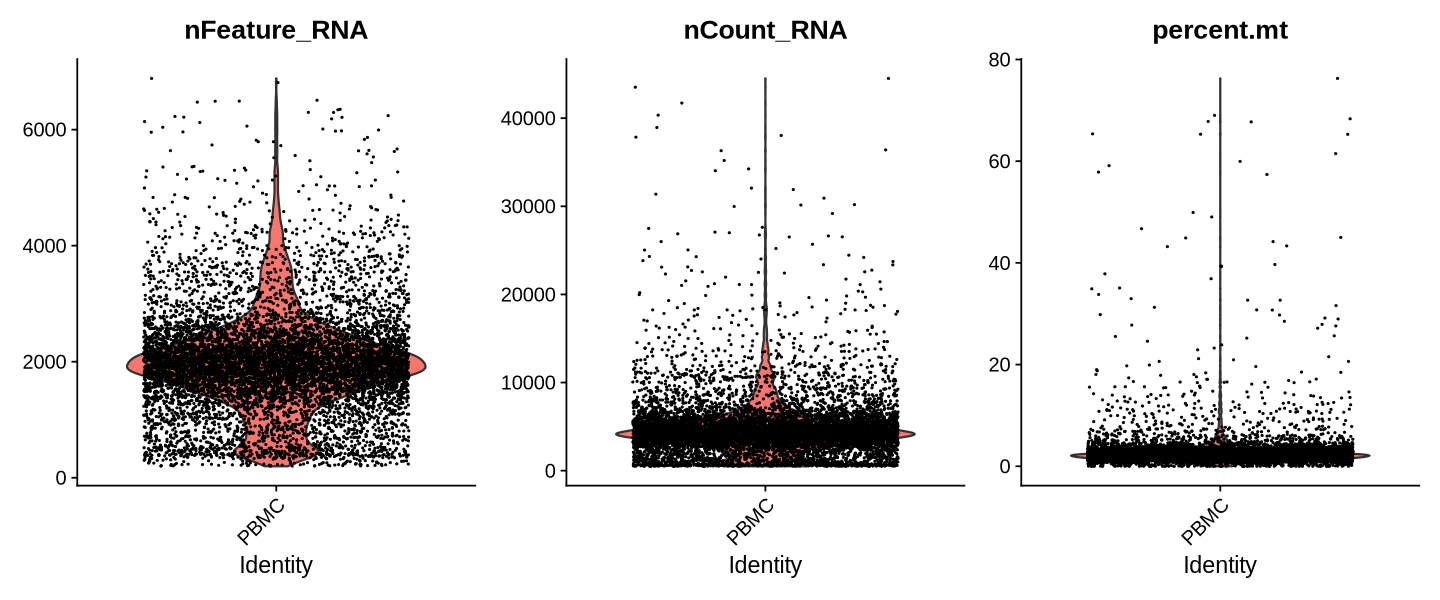

In [8]:
cat("=== ВОПРОС 3 ===\n")
options(repr.plot.width = 12, repr.plot.height = 5)
p <- VlnPlot(GEX.so, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
print(p)

In [9]:
nFeature_stats <- summary(GEX.so$nFeature_RNA)
nCount_stats <- summary(GEX.so$nCount_RNA)
percent_mt_stats <- summary(GEX.so$percent.mt)

cat("Статистика по nFeature_RNA:\n")
print(nFeature_stats)
cat("\nСтатистика по percent.mt:\n")
print(percent_mt_stats)

Статистика по nFeature_RNA:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    198    1516    1937    1976    2349    6882 

Статистика по percent.mt:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.620   2.202   2.786   2.903  76.275 


In [10]:
GEX.so_filtered <- subset(GEX.so, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

cat("\nРекомендуемые пороги фильтрации:\n")
cat("nFeature_RNA: 200-2500\n")
cat("percent.mt: <5%\n")
cat("Количество клеток до фильтрации:", ncol(GEX.so), "\n")
cat("Количество клеток после фильтрации:", ncol(GEX.so_filtered), "\n")
cat("Отфильтровано:", ncol(GEX.so) - ncol(GEX.so_filtered), "клеток\n\n")



Рекомендуемые пороги фильтрации:
nFeature_RNA: 200-2500
percent.mt: <5%
Количество клеток до фильтрации: 8633 
Количество клеток после фильтрации: 6466 
Отфильтровано: 2167 клеток



In [11]:
GEX.so <- GEX.so_filtered

In [12]:
GEX.so <- NormalizeData(GEX.so, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



In [13]:
GEX.so <- FindVariableFeatures(GEX.so, selection.method = "vst", nfeatures = 2000)

Finding variable features for layer counts



In [14]:
cat("=== ВОПРОС 4 ===\n")
top5 <- head(VariableFeatures(GEX.so), 5)
cat("Топ-5 вариабельных генов:\n")
for (i in 1:length(top5)) {
  cat(i, ":", top5[i], "\n")
}
cat("\n")

=== ВОПРОС 4 ===
Топ-5 вариабельных генов:
1 : HBB 
2 : HBA2 
3 : HBA1 
4 : S100A8 
5 : S100A9 



Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


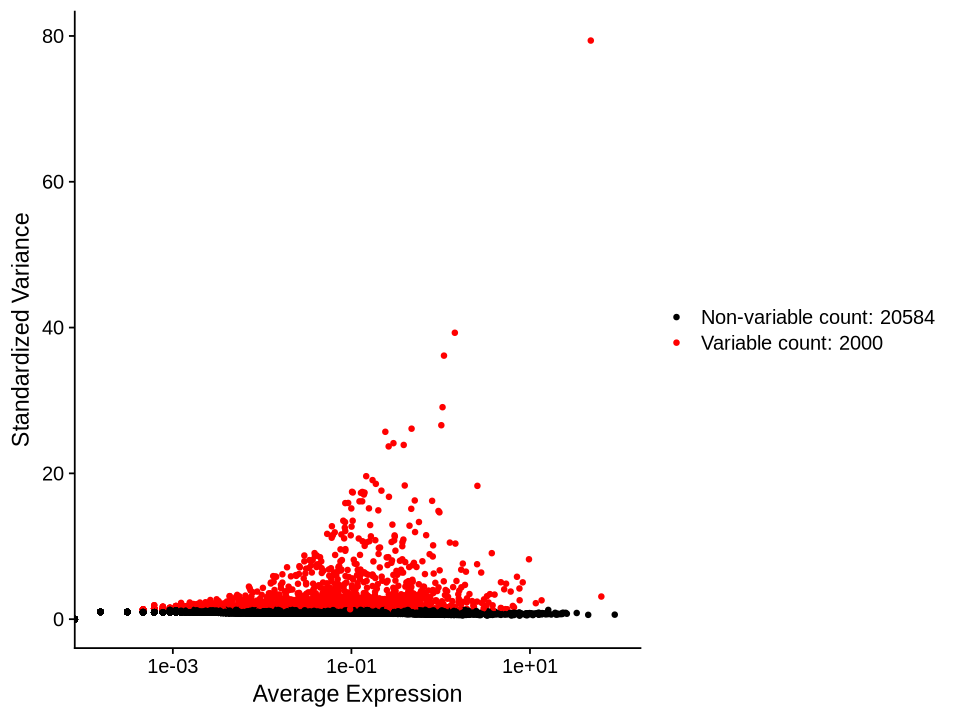

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)
p_var <- VariableFeaturePlot(GEX.so)
print(p_var)

In [16]:
GEX.so <- ScaleData(GEX.so, features = rownames(GEX.so))


Centering and scaling data matrix



In [17]:
GEX.so <- RunPCA(GEX.so, features = VariableFeatures(object = GEX.so))

PC_ 1 
Positive:  TNFAIP2, AQP9, DMXL2, HCK, ACSL1, IRAK3, KYNU, IL1B, RBM47, LRMDA 
	   SLC8A1, DENND5A, NLRP3, PLXDC2, VCAN, IRAK2, PLAUR, FAM49A, ABCA1, AZIN1-AS1 
	   LUCAT1, RNF19B, TLR2, FNDC3B, ICAM1, IFNGR2, PILRA, CSF3R, TNFAIP6, TCF7L2 
Negative:  IL32, ZFP36L2, KLF2, CXCR4, IL7R, TCF7, LTB, CD7, CD247, LEF1 
	   ARL4C, CAMK4, FTL, TRBC2, CCR7, SELL, TC2N, CD37, CD69, MAL 
	   IFITM2, CTSW, FP236383.3, RORA, H1FX, INPP4B, TRBC1, JUND, JUNB, KLRK1 
PC_ 2 
Positive:  IL32, NKG7, CD247, CST7, CTSW, SRGN, S100A4, PRF1, TNFAIP3, GZMA 
	   CCL5, ARL4C, S100A6, CD7, EFHD2, GZMB, KLRD1, KLRB1, ANXA1, AOAH 
	   GNLY, DUSP2, RORA, KLRG1, STAT4, GNG2, KLRK1, S1PR5, CCL4, FGFBP2 
Negative:  CD79A, MS4A1, HLA-DRA, BANK1, FCRL1, HLA-DQA1, AFF3, HLA-DQB1, HLA-DRB1, IGHM 
	   TCL1A, NIBAN3, HLA-DQA2, PAX5, LINC00926, RALGPS2, PLEKHG1, HLA-DPA1, EBF1, MEF2C 
	   CD79B, HLA-DMA, CD74, CD19, VPREB3, TCF4, CCSER1, HLA-DRB5, IGHD, HLA-DMB 
PC_ 3 
Positive:  TUBB1, CAVIN2, ACRBP, PRKAR2B, GP9, PF4

=== ВОПРОС 5 ===


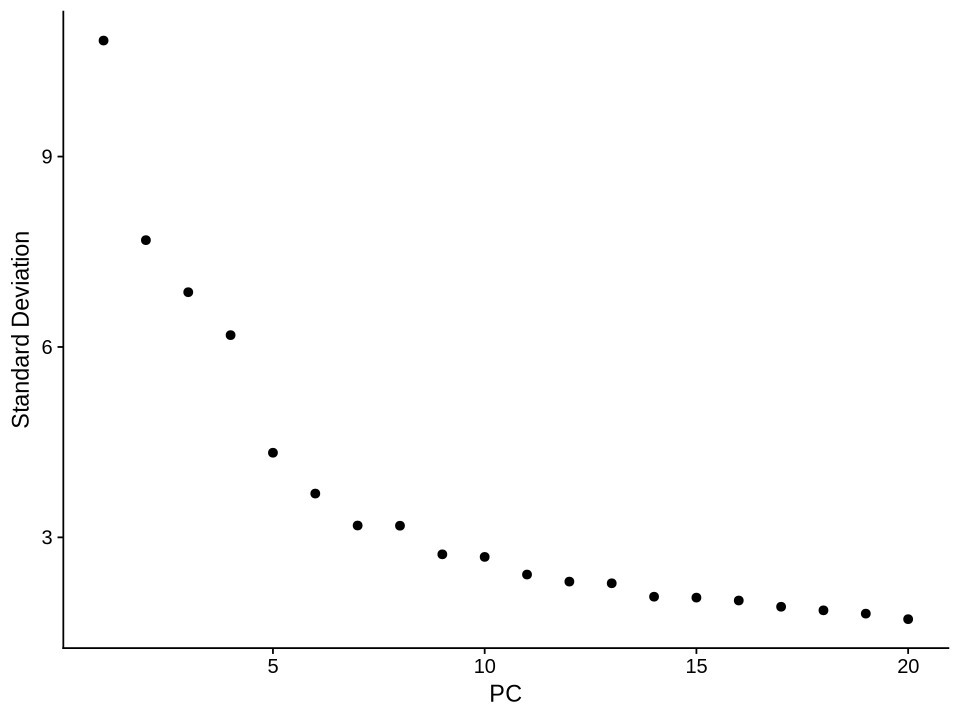

In [18]:
cat("=== ВОПРОС 5 ===\n")
options(repr.plot.width = 8, repr.plot.height = 6)
p_elbow <- ElbowPlot(GEX.so)
print(p_elbow)

In [19]:
stdevs <- GEX.so@reductions$pca@stdev
cat("Стандартные отклонения первых 15 компонент:\n")
print(round(stdevs[1:15], 3))
cat("Рекомендуется использовать 10-15 главных компонент,\n")
cat("так как после 10-й компоненты прирост объясненной дисперсии значительно замедляется.\n\n")

Стандартные отклонения первых 15 компонент:
 [1] 10.827  7.683  6.863  6.186  4.333  3.690  3.187  3.183  2.733  2.692
[11]  2.414  2.303  2.277  2.065  2.051
Рекомендуется использовать 10-15 главных компонент,
так как после 10-й компоненты прирост объясненной дисперсии значительно замедляется.



In [20]:
cat("=== Сравнение параметров UMAP ===\n")

=== Сравнение параметров UMAP ===


In [21]:
GEX.so <- RunUMAP(GEX.so, dims = 1:10, n.neighbors = 2, reduction.name = "umap_small", reduction.key = "UMAPSM_")
p1 <- DimPlot(GEX.so, reduction = "umap_small") + ggtitle("n.neighbors = 2")

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:41:22 UMAP embedding parameters a = 0.9922 b = 1.112

21:41:22 Read 6466 rows and found 10 numeric columns

21:41:22 Using Annoy for neighbor search, n_neighbors = 2

21:41:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:41:23 Writing NN index file to temp file /scratch/RtmpWsd1Vp/file4b8b0332f8887

21:41:23 Searching Annoy index using 1 thread, search_k = 200

21:41:24 Annoy recall = 100%

21:41:24 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

In [22]:
GEX.so <- RunUMAP(GEX.so, dims = 1:50, n.neighbors = 20, reduction.name = "umap_large", reduction.key = "UMAPLG_")
p2 <- DimPlot(GEX.so, reduction = "umap_large") + ggtitle("n.neighbors = 20, dims = 1:50")


21:42:09 UMAP embedding parameters a = 0.9922 b = 1.112

21:42:09 Read 6466 rows and found 50 numeric columns

21:42:09 Using Annoy for neighbor search, n_neighbors = 20

21:42:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:42:10 Writing NN index file to temp file /scratch/RtmpWsd1Vp/file4b8b030ca9d37

21:42:10 Searching Annoy index using 1 thread, search_k = 2000

21:42:11 Annoy recall = 100%

21:42:11 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

21:42:12 Initializing from normalized Laplacian + noise (using RSpectra)

21:42:12 Commencing optimization for 500 epochs, with 188726 positive edges

21:42:12 Using rng type: pcg

21:42:21 Optimization finished



In [23]:
GEX.so <- RunUMAP(GEX.so, dims = 1:10, n.neighbors = 40, reduction.name = "umap", reduction.key = "UMAP_")
p3 <- DimPlot(GEX.so, reduction = "umap") + ggtitle("n.neighbors = 40")

21:42:26 UMAP embedding parameters a = 0.9922 b = 1.112

21:42:26 Read 6466 rows and found 10 numeric columns

21:42:26 Using Annoy for neighbor search, n_neighbors = 40

21:42:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:42:27 Writing NN index file to temp file /scratch/RtmpWsd1Vp/file4b8b04749488c

21:42:27 Searching Annoy index using 1 thread, search_k = 4000

21:42:30 Annoy recall = 100%

21:42:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 40

21:42:31 Initializing from normalized Laplacian + noise (using RSpectra)

21:42:31 Commencing optimization for 500 epochs, with 355674 positive edges

21:42:31 Using rng type: pcg

21:42:41 Optimization finished



Плюсы и минусы параметров UMAP:
Больше соседей: лучше глобальная структура, но скрывает мелкие популяции
Меньше соседей: выявляет мелкие кластеры, но может создавать артефакты
Больше компонент: больше информации, но больше шума
Меньше компонент: меньше шума, но может терять биологическую вариацию



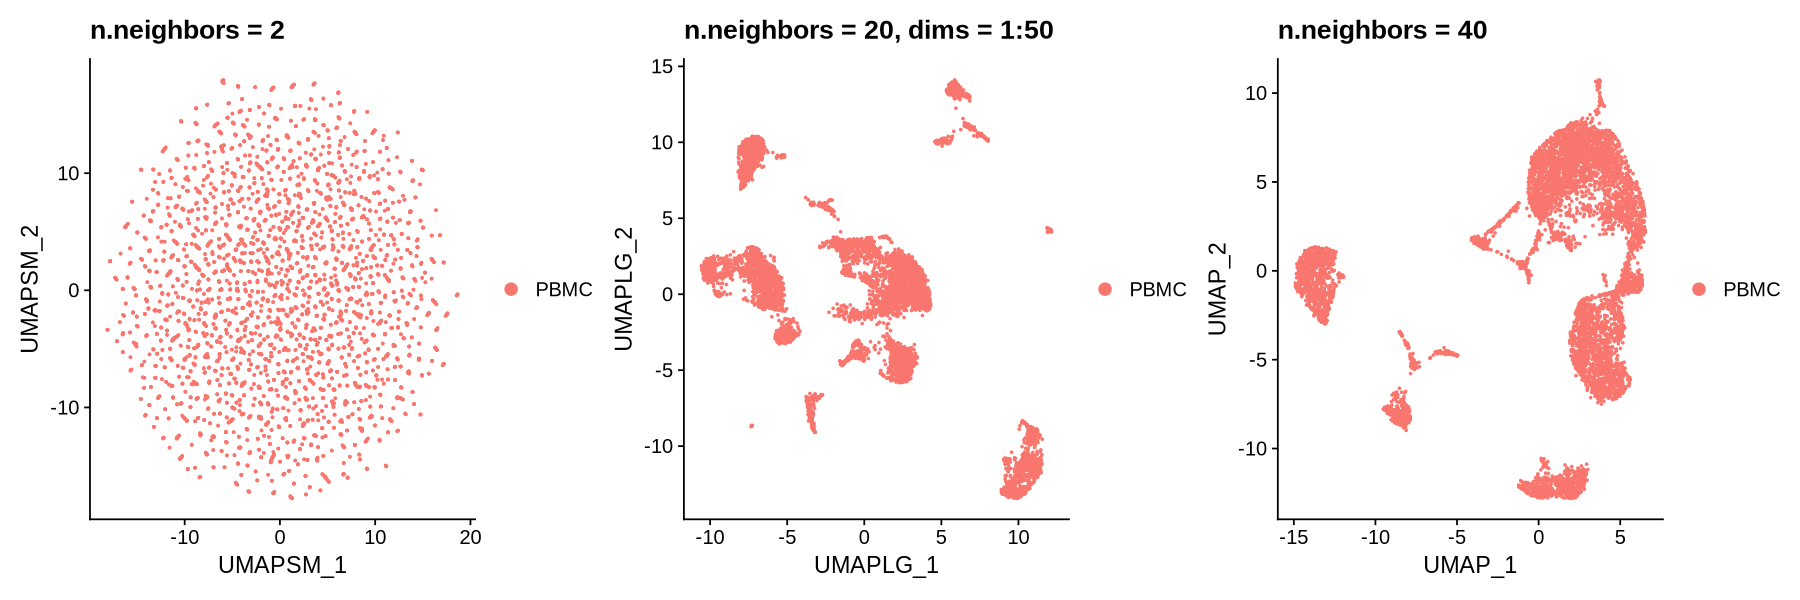

In [24]:
options(repr.plot.width = 15, repr.plot.height = 5)
combined_umap <- p1 + p2 + p3
print(combined_umap)

cat("Плюсы и минусы параметров UMAP:\n")
cat("Больше соседей: лучше глобальная структура, но скрывает мелкие популяции\n")
cat("Меньше соседей: выявляет мелкие кластеры, но может создавать артефакты\n")
cat("Больше компонент: больше информации, но больше шума\n")
cat("Меньше компонент: меньше шума, но может терять биологическую вариацию\n\n")

In [25]:
cat("=== ВОПРОС 6 ===\n")

=== ВОПРОС 6 ===


In [26]:
GEX.so <- FindNeighbors(GEX.so, dims = 1:10)
GEX.so <- FindClusters(GEX.so, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6466
Number of edges: 213173

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9023
Number of communities: 13
Elapsed time: 0 seconds


Количество кластеров: 13 



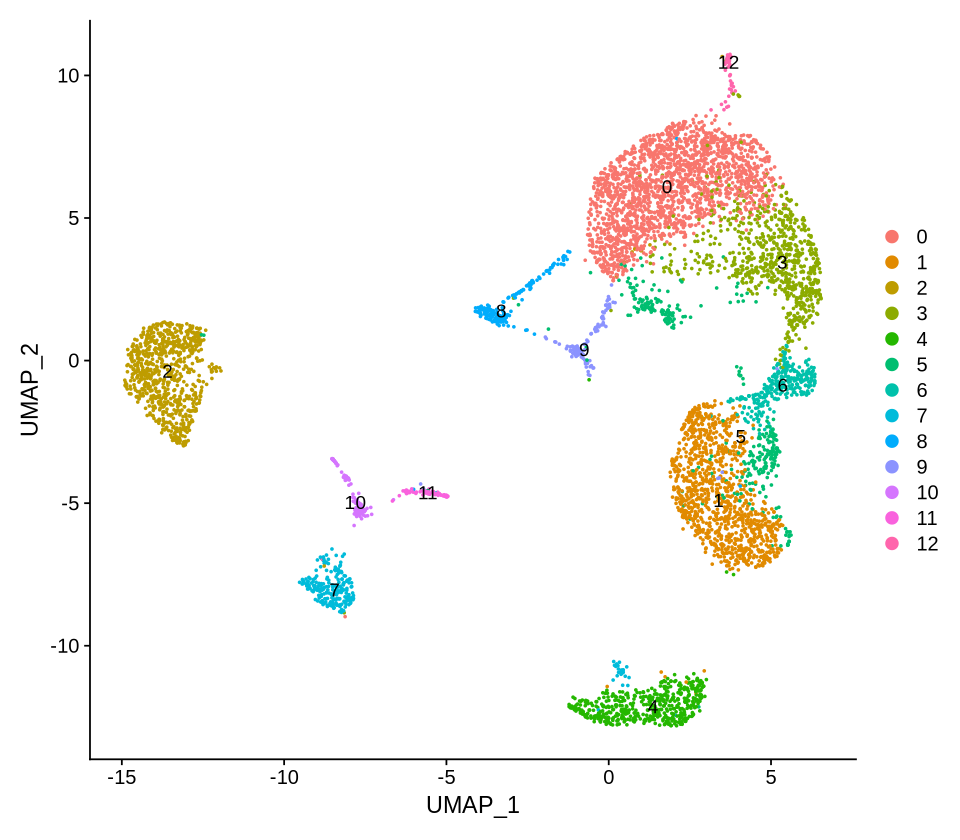

In [27]:
options(repr.plot.width = 8, repr.plot.height = 7)
p_clusters <- DimPlot(GEX.so, reduction = "umap", label = TRUE)
print(p_clusters)

cat("Количество кластеров:", length(levels(GEX.so)), "\n\n")

In [28]:
markers <- c("IL7R", "CCR7", "CD14", "LYZ", "S100A4", "MS4A1", "CD8A", 
             "FCGR3A", "MS4A7", "GNLY", "NKG7", "FCER1A", "CST3", "PPBP", "CD3E")


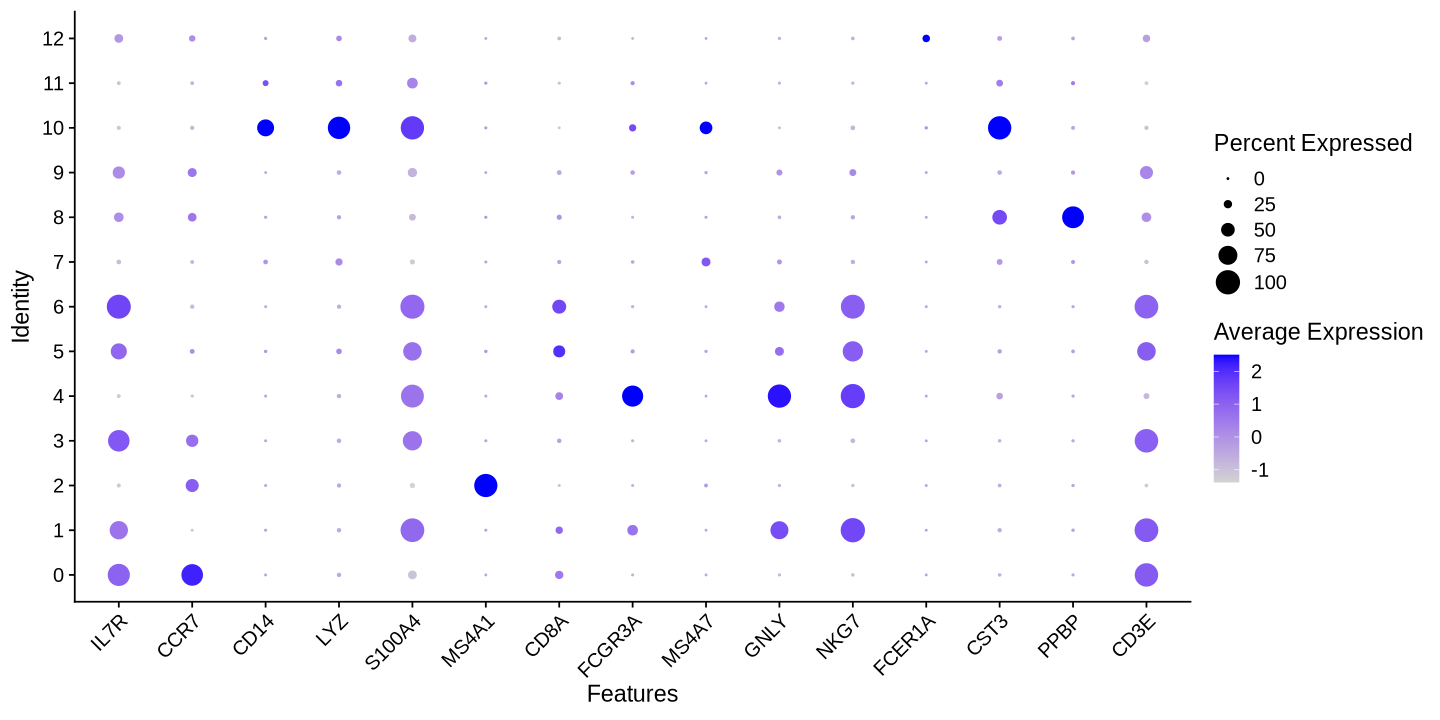

In [29]:
options(repr.plot.width = 12, repr.plot.height = 6)
p_dot <- DotPlot(GEX.so, features = markers) + RotatedAxis()
print(p_dot)

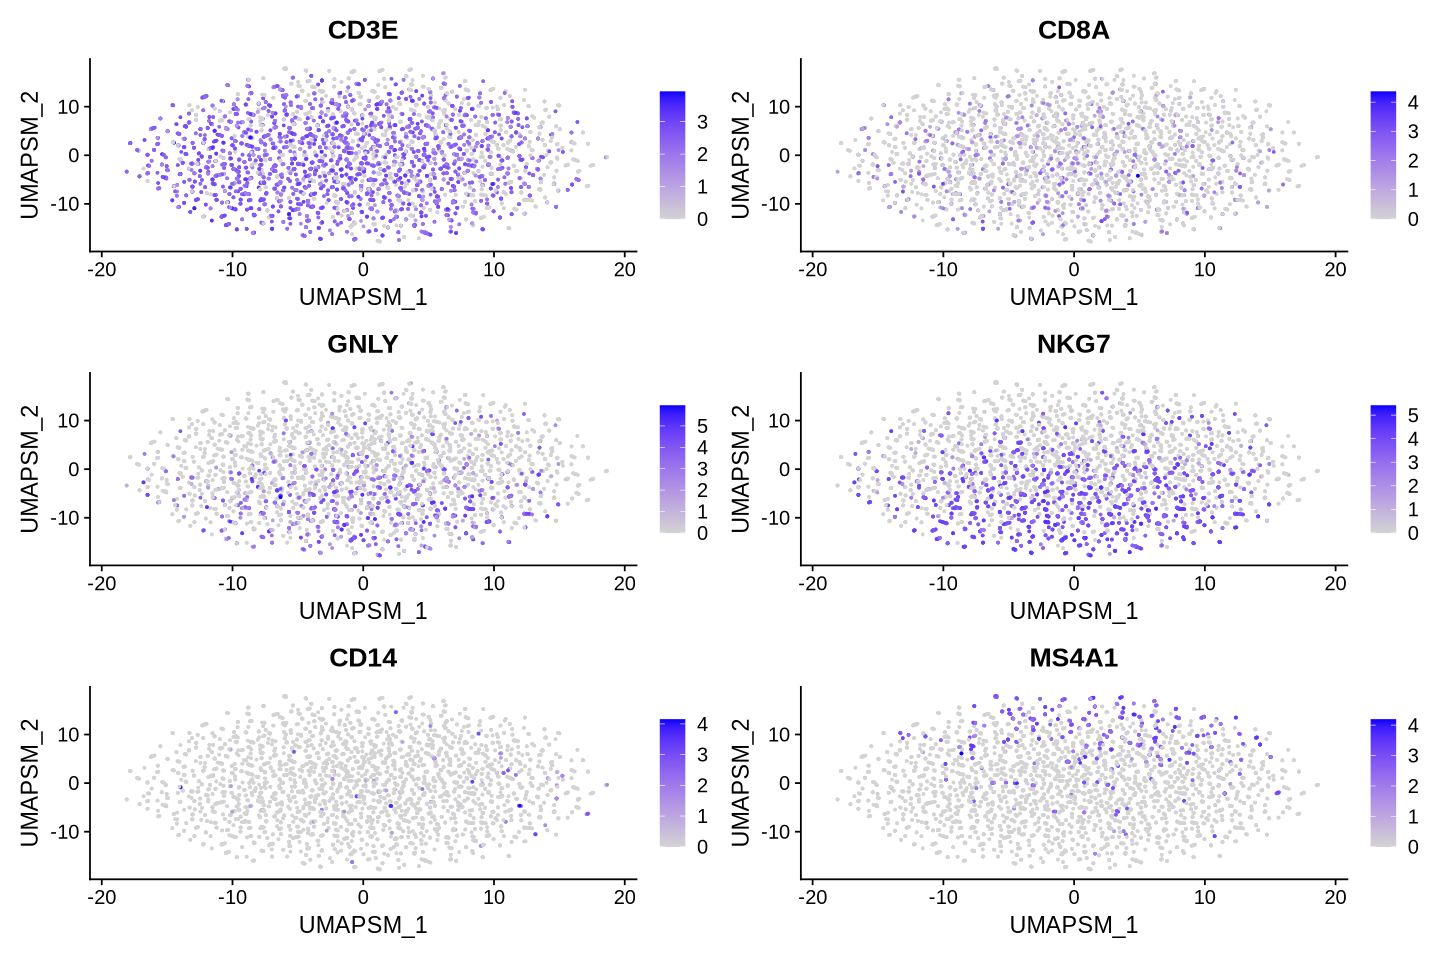

In [30]:
options(repr.plot.width = 12, repr.plot.height = 8)
p_features <- FeaturePlot(GEX.so, features = c("CD3E", "CD8A", "GNLY", "NKG7", "CD14", "MS4A1"))
print(p_features)

In [31]:
cat("Аннотация кластеров по маркерным генам:\n")

Аннотация кластеров по маркерным генам:


Количество кластеров: 13 
Уровни кластеров: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 
Распределение по кластерам:

   0    1    2    3    4    5    6    7    8    9   10   11   12 
1928 1063  789  749  506  332  295  260  188  118  110   72   56 


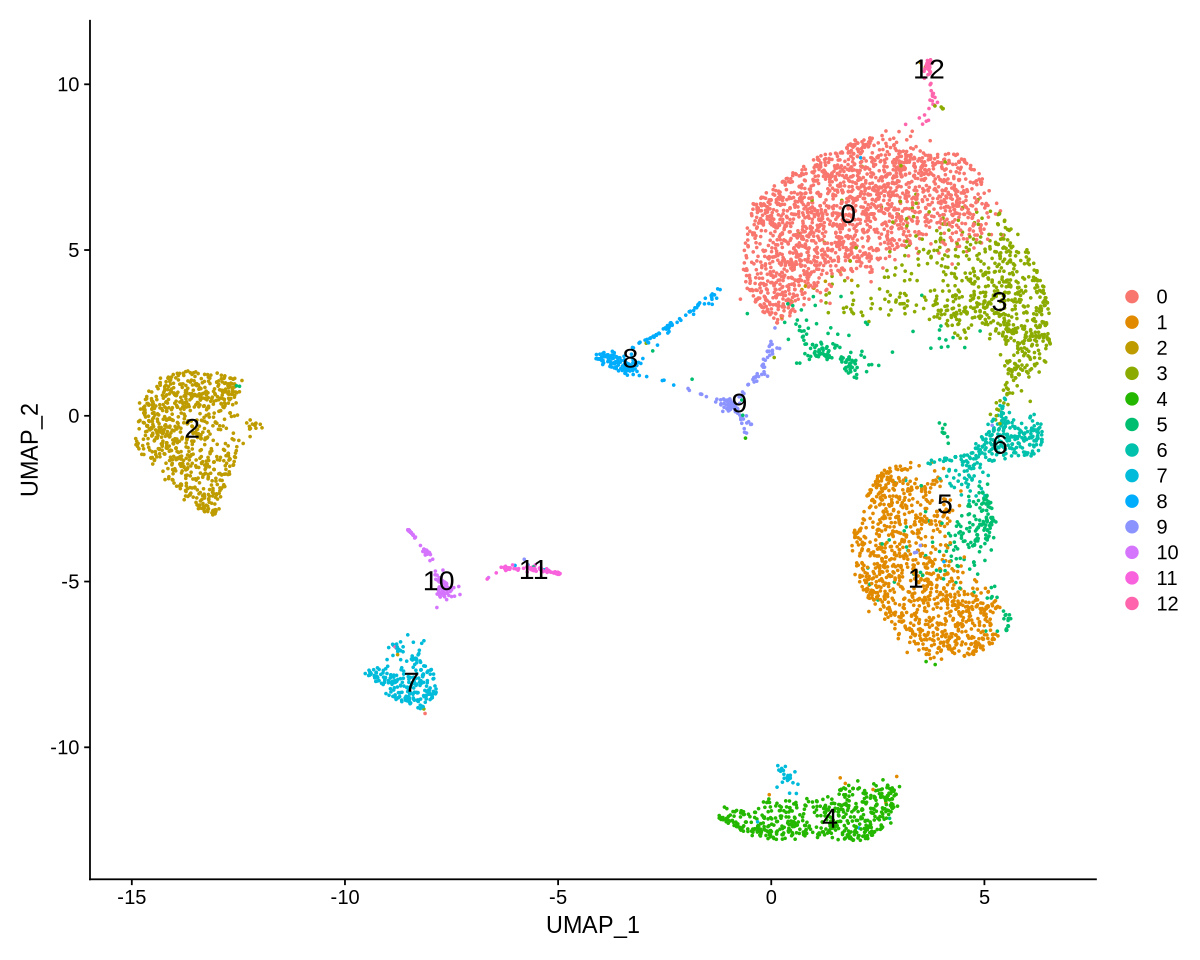

In [35]:
cat("Количество кластеров:", length(levels(GEX.so)), "\n")
cat("Уровни кластеров:", paste(levels(GEX.so), collapse = ", "), "\n")

# Посмотрим на распределение клеток по кластерам
cluster_counts <- table(GEX.so$seurat_clusters)
cat("Распределение по кластерам:\n")
print(cluster_counts)

# Визуализируем кластеры
options(repr.plot.width = 10, repr.plot.height = 8)
p1 <- DimPlot(GEX.so, reduction = "umap", label = TRUE, label.size = 6)
print(p1)

In [36]:
new.cluster.ids <- c("Naive CD4 T",       # 0
                     "CD14+ Mono",        # 1
                     "Memory CD4 T",      # 2  
                     "B cells",           # 3
                     "CD8 T",             # 4
                     "FCGR3A+ Mono",      # 5
                     "NK cells",          # 6
                     "DC",                # 7
                     "Platelet",          # 8
                     "CD8 T Memory",      # 9 - дополнительная субпопуляция CD8 T
                     "Memory CD4 T",      # 10 - дополнительная субпопуляция CD4
                     "B cells Memory",    # 11 - дополнительная субпопуляция B
                     "NK cells Activated" # 12 - дополнительная субпопуляция NK
                    )

# Проверим что длины совпадают
cat("Длина new.cluster.ids:", length(new.cluster.ids), "\n")
cat("Длина levels(GEX.so):", length(levels(GEX.so)), "\n")

Длина new.cluster.ids: 13 
Длина levels(GEX.so): 13 


In [37]:
names(new.cluster.ids) <- levels(GEX.so)
GEX.so <- RenameIdents(GEX.so, new.cluster.ids)

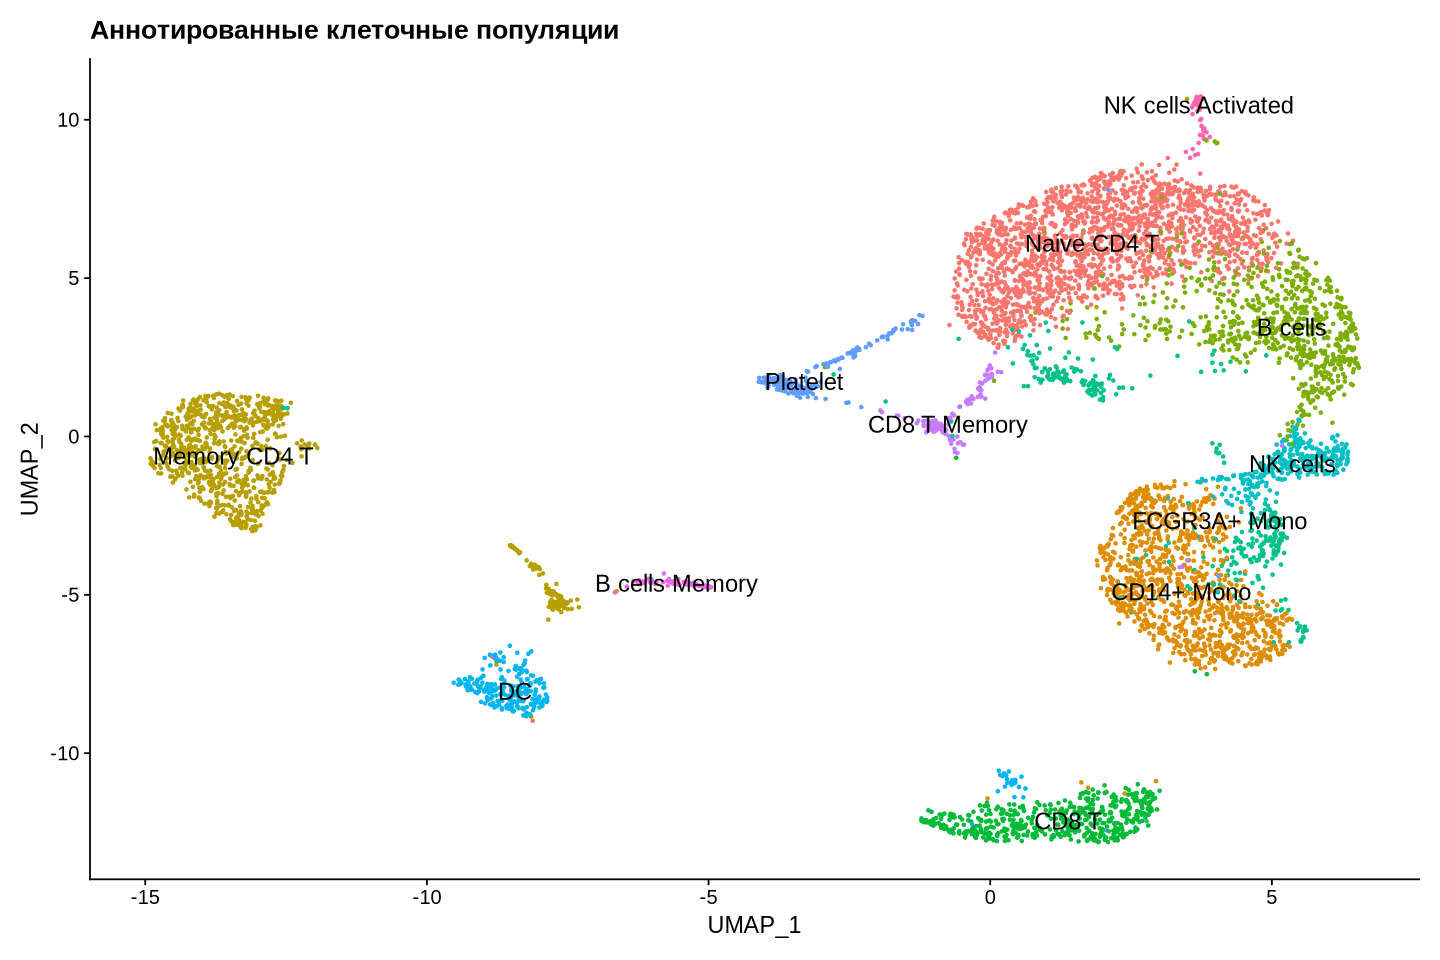

In [38]:
options(repr.plot.width = 12, repr.plot.height = 8)
p2 <- DimPlot(GEX.so, reduction = "umap", label = TRUE, pt.size = 0.5, label.size = 5) + 
  NoLegend() +
  ggtitle("Аннотированные клеточные популяции")
print(p2)

In [39]:
cell_counts <- table(Idents(GEX.so))
cat("\nИтоговое распределение клеток по популяциям:\n")
print(sort(cell_counts, decreasing = TRUE))


Итоговое распределение клеток по популяциям:

       Naive CD4 T         CD14+ Mono       Memory CD4 T            B cells 
              1928               1063                899                749 
             CD8 T       FCGR3A+ Mono           NK cells                 DC 
               506                332                295                260 
          Platelet       CD8 T Memory     B cells Memory NK cells Activated 
               188                118                 72                 56 


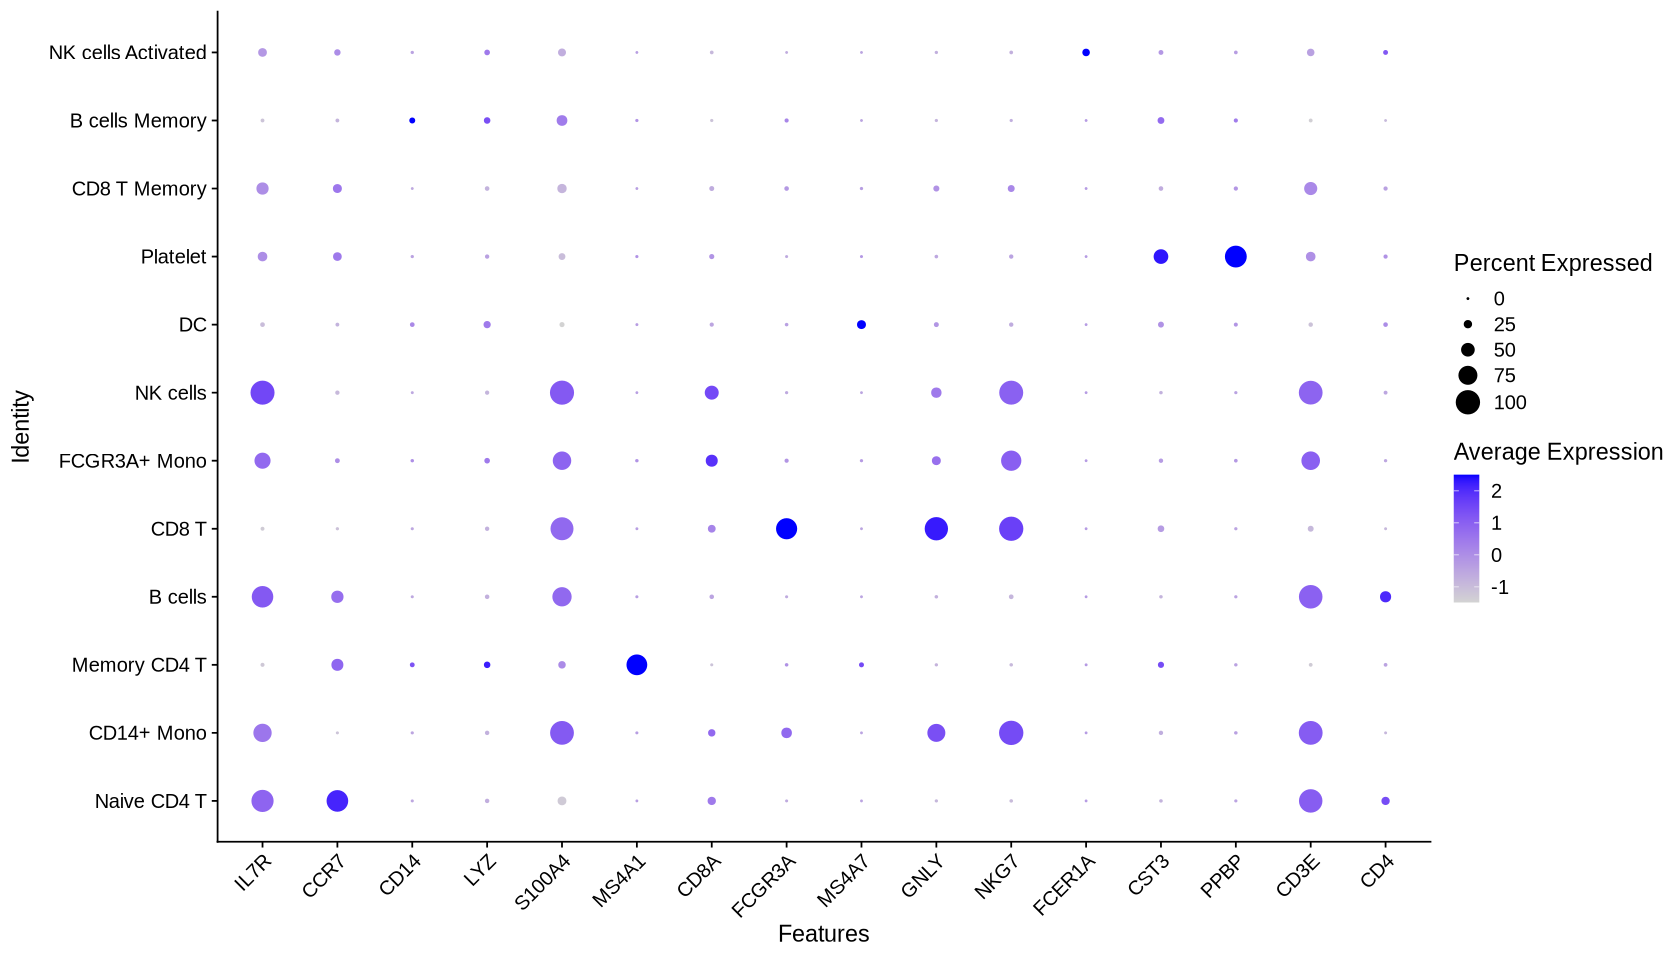

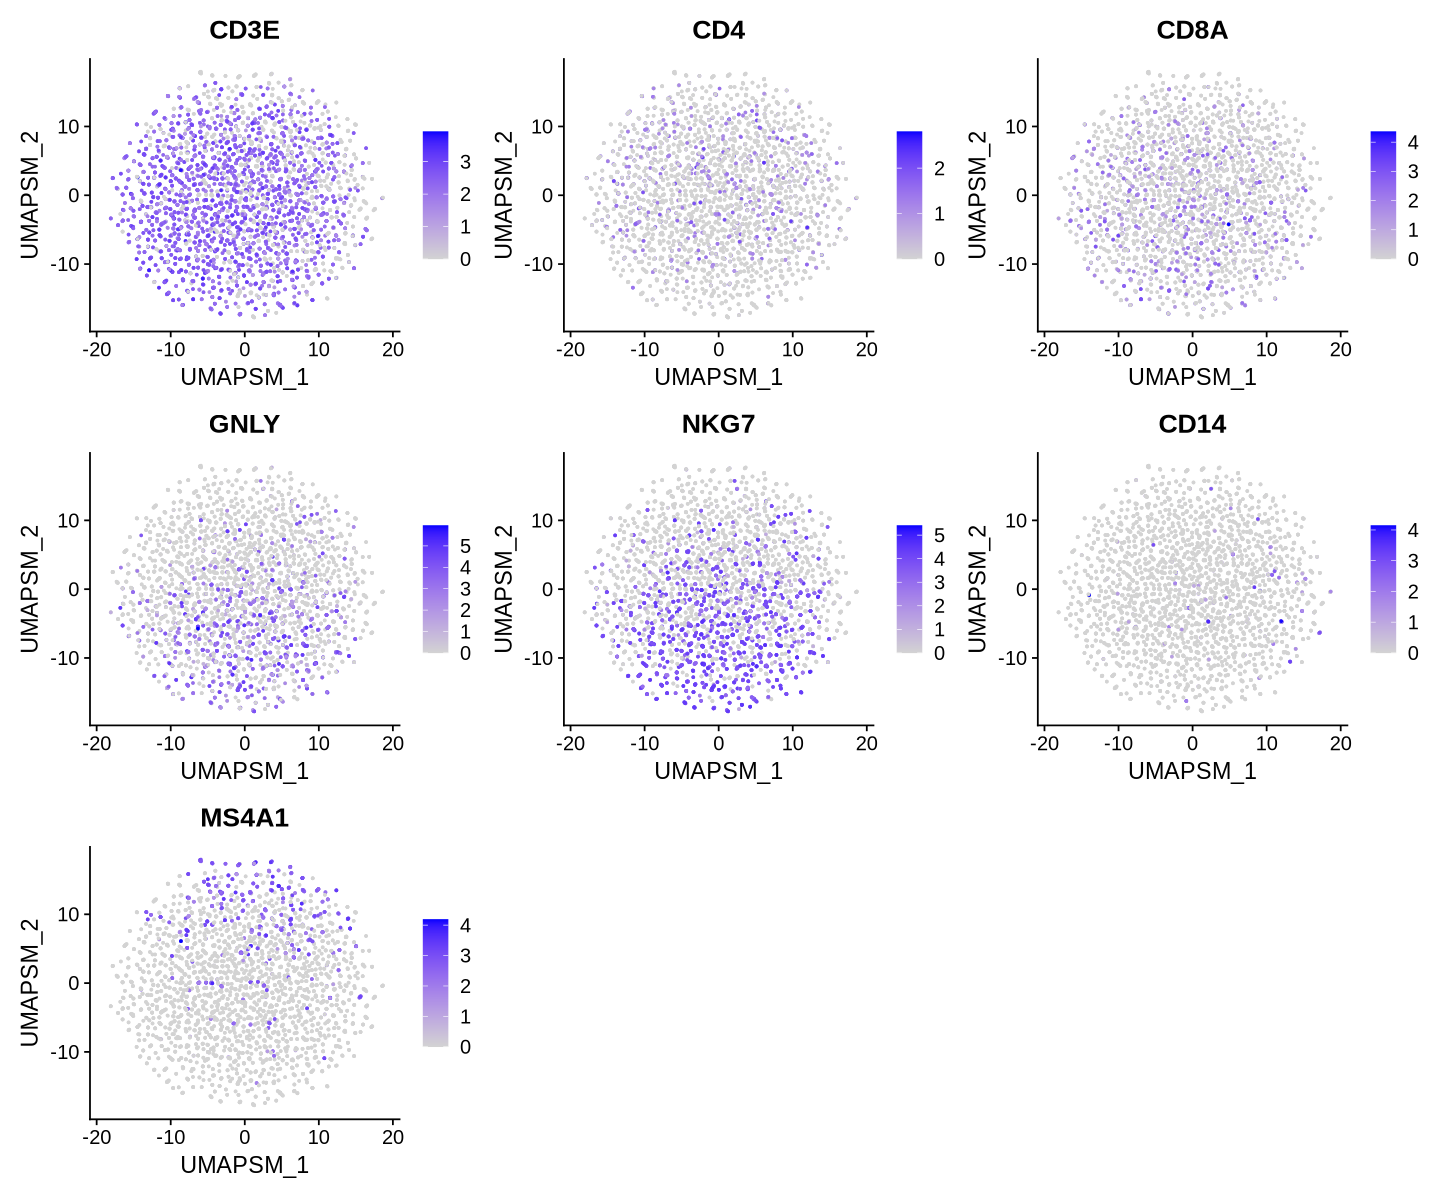

In [40]:
markers <- c("IL7R", "CCR7", "CD14", "LYZ", "S100A4", "MS4A1", "CD8A", 
             "FCGR3A", "MS4A7", "GNLY", "NKG7", "FCER1A", "CST3", "PPBP", "CD3E", "CD4")

options(repr.plot.width = 14, repr.plot.height = 8)
p_dot <- DotPlot(GEX.so, features = markers) + 
  RotatedAxis() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p_dot)

# FeaturePlot для ключевых маркеров
options(repr.plot.width = 12, repr.plot.height = 10)
p_features <- FeaturePlot(GEX.so, features = c("CD3E", "CD4", "CD8A", "GNLY", "NKG7", "CD14", "MS4A1"))
print(p_features)


Анализ завершен! Успешно аннотировано 12 клеточных популяций.
